# **NDSI**
Usually when we use a hyperspectral camera we **compare the signal received by the camera** (the reflected radiation at different wavelengths) **and a measurement we made** and try to find the correlations and the mathematical relationship between the two. In my case I have gas exchange measurements measured with the LI-6800 system and I want to find the correlations of the gas exchange rate values (water and carbon dioxide) and the signal received by the camera.

Since each pixel in the camera contains reflected radiation in 204 different wavelengths, we need to process the signal received from the camera and look for which wavelengths correlate to the gas exchange values. 

One of the common methods is to calculate all possible combinations of the values of the normalized distance between two wavelengths using the following formula:

$$\frac{a-b}{a+b}$$


while:

* **a** is the reflectence on 1 wavelengh
* **b** is the reflectence of the other.

In this notebook I will **calculate all the possible combinations between 2 different wavelengths and the correlation of each of them to the gas exchange parameter**.

In [1]:
import pandas as pd
import numpy as np
from scipy import stats
import itertools
from itertools import combinations
import matplotlib.pyplot as plt
import seaborn as sns
# Set the font to Times new roman
plt.rcParams['font.family'] = 'serif'
plt.rcParams['font.serif'] = ['Times New Roman'] + plt.rcParams['font.serif']

In [2]:
def NDSI(x_df,y_df):
  ## create list of all possible pairs of bands:
  x_df.columns = x_df.columns.map(str) # Convert columns names to str
  bands_list = x_df.columns
  all_pairs = list(itertools.combinations(bands_list, 2)) # All possible pairs of columns
  print("1 done") # for debug
  
  ## Calculate the NDSI
  y = y_df.values
  corrs = np.zeros(len(all_pairs)) # array for fill with correlation values
  pvals = np.zeros(len(all_pairs)) # array for fill with p values
  print("2 done") # for debug
  for index, pair in enumerate(all_pairs):
    a = x_df[pair[0]].values
    b = x_df[pair[1]].values
    Norm_index = np.subtract(a,b)/np.add(a,b)
    ## Spearman correlation and p value
    corrs[index] = stats.spearmanr(Norm_index, y)[0]
    pvals[index] = stats.spearmanr(Norm_index, y)[1]
  print("3 done") # for debug
  
  ## Convert to DataFrame
  col1 = [tple[0] for tple in all_pairs] # column of the first wavelengh
  col2 = [tple[1] for tple in all_pairs] # column of the second wavelengh
  index_col = [str(tple[0])+","+str(tple[1]) for tple in all_pairs] # index column
  data = {'band1':col1,"band2":col2,'Spearman_Corr': corrs, 'p_value': pvals}
  df_results = pd.DataFrame(index = index_col ,data=data)
  df_results["Abs_Spearman_Corr"] = df_results["Spearman_Corr"].abs()
  print("4 done") # for debug
  return df_results

In [3]:
df = pd.read_csv("/content/drive/MyDrive/Greenwall/Hyperspectral_data/All_data/licor_hs_final.csv")
# drop Nan (21 samples)
df = df.dropna() 
# df = df.loc[180:]

In [4]:
# x_df = df[df.columns[16:-2]]
# x_df.columns = x_df.columns.map(str) # Convert columns names to str
# bands_list = x_df.columns
# all_pairs = [(a,b) for a in bands_list for b in bands_list if a != b] # All possible pairs of columns
# all_pairs = list(itertools.combinations(bands_list, 2))
# len(set(all_pairs)),len(all_pairs)
# len(all_pairs)
# np.zeros(len(all_pairs))
# col_index = [str(tple[0])+","+str(tple[1]) for tple in all_pairs]
# pd.DataFrame(index=col_index)

In [5]:
results = NDSI(df[df.columns[16:-2]],df['A'])

1 done
2 done
3 done
4 done


In [6]:
results.sort_values('Abs_Spearman_Corr')

,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"484.23,592.7",484.23,592.7,0.000041,9.994315e-01,0.000041
"519.25,883.79",519.25,883.79,0.000049,9.993292e-01,0.000049
"762.57,768.6",762.57,768.6,0.000060,9.991728e-01,0.000060
"519.25,838.14",519.25,838.14,-0.000066,9.990826e-01,0.000066
"469.68,871.6",469.68,871.6,-0.000070,9.990284e-01,0.000070
...,...,...,...,...,...
"951.17,1003.58",951.17,1003.58,0.371241,2.657414e-11,0.371241
"810.86,813.89",810.86,813.89,0.374812,1.655328e-11,0.374812
"960.4,1003.58",960.4,1003.58,0.376733,1.280120e-11,0.376733
"957.32,1003.58",957.32,1003.58,0.379089,9.318449e-12,0.379089


As you can see the highest correlation value (according to the Spearman coefficient) is 0.38. **This result is not good enough for us**, so we will try to check two more directions:

1. Instead of calculating a value for each wavelength, we will **perform an average over every few wavelengths (3-5) and check whether in this case the correlation is stronger**. This option is reasonable considering that each wavelength has a very small amount of radiation, so it may be correct to take an average of several wavelengths. We will compare the average value to the gas exchange parameter.
2. We will look for **the correlation between the average value for each species for all wavelengths**. Each sample will actually be an average of all samples for that species.

##**1.  Mean of all every n bands**

In [7]:
n = 4                                          # define how much column to average
x = df[df.columns[16:-2]].to_numpy()           
cols = np.arange(0,205,n)                      # array for index
df_avg = pd.DataFrame()                        # empty df
for index, elem in enumerate(cols):
  if (index+1 < len(cols) and index - 1 >= 0): # without the last time
    data = x[:, elem:cols[index+1]]            # data of the cols
    Avg = data.mean(axis=1)                    # mean
    df_avg[elem] = Avg                         # column of the avg data

df_avg

,4,8,12,16,20,24,28,32,36,40,...,164,168,172,176,180,184,188,192,196,200
0,0.102729,0.096446,0.099067,0.106523,0.101206,0.091274,0.084699,0.085537,0.091760,0.106145,...,0.577716,0.573488,0.568163,0.555858,0.530833,0.500045,0.469835,0.461475,0.463158,0.463146
1,0.127849,0.114121,0.118514,0.133655,0.127241,0.109089,0.097916,0.099615,0.110815,0.138592,...,0.884553,0.877430,0.871601,0.854403,0.818871,0.769523,0.721534,0.715335,0.726235,0.716256
2,0.137080,0.127087,0.139570,0.162443,0.152495,0.127841,0.112590,0.116445,0.130867,0.156940,...,0.852495,0.847886,0.841680,0.822285,0.781726,0.725902,0.671042,0.668095,0.679957,0.668680
3,0.072010,0.053180,0.044883,0.043770,0.041615,0.037646,0.035244,0.035227,0.039833,0.058155,...,0.742142,0.739993,0.731777,0.714627,0.679631,0.629360,0.576885,0.573003,0.579118,0.570152
4,0.093734,0.069712,0.055708,0.051488,0.050010,0.047048,0.044130,0.043610,0.049811,0.074263,...,0.796412,0.791963,0.785253,0.766263,0.726326,0.670664,0.613284,0.605888,0.622431,0.621344
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
297,0.068836,0.044563,0.028410,0.019587,0.018437,0.019089,0.018778,0.017301,0.017253,0.021895,...,0.708105,0.702495,0.698800,0.678913,0.638601,0.584152,0.529720,0.521344,0.537949,0.536014
298,0.070001,0.050912,0.042368,0.042974,0.040307,0.034087,0.029244,0.028388,0.030127,0.036065,...,0.807667,0.804831,0.797093,0.782171,0.743008,0.681783,0.626458,0.617136,0.632695,0.629681
299,0.078025,0.058145,0.048132,0.046675,0.046942,0.043664,0.040765,0.043647,0.057882,0.085087,...,0.555834,0.552671,0.553972,0.546084,0.529217,0.511599,0.488902,0.486346,0.493142,0.483210
300,0.081162,0.060301,0.049594,0.045548,0.044233,0.042002,0.040061,0.040209,0.045721,0.060627,...,0.559674,0.558718,0.560533,0.558469,0.544078,0.526769,0.507810,0.512434,0.518221,0.505816


In [8]:
results_Avg = NDSI(df_avg,df['A'])

1 done
2 done
3 done
4 done


In [9]:
results_Avg.sort_values('Abs_Spearman_Corr')

,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"132,164",132,164,0.000182,9.974883e-01,0.000182
"148,156",148,156,-0.000201,9.972297e-01,0.000201
"40,148",40,148,-0.000222,9.969409e-01,0.000222
"76,104",76,104,0.000284,9.960746e-01,0.000284
"40,144",40,144,0.000444,9.938668e-01,0.000444
...,...,...,...,...,...
"40,100",40,100,0.304891,6.455041e-08,0.304891
"44,100",44,100,0.312515,2.889746e-08,0.312515
"192,200",192,200,0.320374,1.232049e-08,0.320374
"188,200",188,200,0.338010,1.660283e-09,0.338010


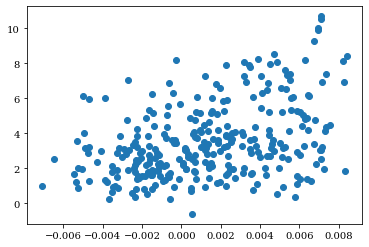

In [10]:
a = df['807.84']-df['813.89']
b = df['807.84']+df['813.89']
c = a/b
plt.scatter(c,df['A'])

Lets average the most correlated bands manually:

In [26]:
# Normalized index
def Avg_nvi_column(df,list1,list2):
  # crete matrix and calculate mean:
  mean1 = df[list1].mean(axis=1).values # mean of raws
  mean2 = df[list2].mean(axis=1).values # mean of raws

  data = (mean1-mean2)/(mean1 + mean2)
  return data 

# fraction index
def Avg_frac_column(df,list1,list2):
  mean1 = df[list1].mean(axis=1).values # mean of raws
  mean2 = df[list2].mean(axis=1).values # mean of raws
  data = mean1/mean2
  return data 

In [27]:
bands = np.arange(0,204,1)
wavelength = [397.32, 400.2, 403.09, 405.97, 408.85, 411.74, 414.63, 417.52, 420.4, 423.29, 426.19, 429.08, 431.97, 434.87, 437.76, 440.66, 443.56, 446.45, 449.35, 452.25, 455.16, 458.06, 460.96, 463.87, 466.77, 469.68, 472.59, 475.5, 478.41, 481.32, 484.23, 487.14, 490.06, 492.97, 495.89, 498.8, 501.72, 504.64, 507.56, 510.48, 513.4, 516.33, 519.25, 522.18, 525.1, 528.03, 530.96, 533.89, 536.82, 539.75, 542.68, 545.62, 548.55, 551.49, 554.43, 557.36, 560.3, 563.24, 566.18, 569.12, 572.07, 575.01, 577.96, 580.9, 583.85, 586.8, 589.75, 592.7, 595.65, 598.6, 601.55, 604.51, 607.46, 610.42, 613.38, 616.34, 619.3, 622.26, 625.22, 628.18, 631.15, 634.11, 637.08, 640.04, 643.01, 645.98, 648.95, 651.92, 654.89, 657.87, 660.84, 663.81, 666.79, 669.77, 672.75, 675.73, 678.71, 681.69, 684.67, 687.65, 690.64, 693.62, 696.61, 699.6, 702.58, 705.57, 708.57, 711.56, 714.55, 717.54, 720.54, 723.53, 726.53, 729.53, 732.53, 735.53, 738.53, 741.53, 744.53, 747.54, 750.54, 753.55, 756.56, 759.56, 762.57, 765.58, 768.6, 771.61, 774.62, 777.64, 780.65, 783.67, 786.68, 789.7, 792.72, 795.74, 798.77, 801.79, 804.81, 807.84, 810.86, 813.89, 816.92, 819.95, 822.98, 826.01, 829.04, 832.07, 835.11, 838.14, 841.18, 844.22, 847.25, 850.29, 853.33, 856.37, 859.42, 862.46, 865.5, 868.55, 871.6, 874.64, 877.69, 880.74, 883.79, 886.84, 889.9, 892.95, 896.01, 899.06, 902.12, 905.18, 908.24, 911.3, 914.36, 917.42, 920.48, 923.55, 926.61, 929.68, 932.74, 935.81, 938.88, 941.95, 945.02, 948.1, 951.17, 954.24, 957.32, 960.4, 963.47, 966.55, 969.63, 972.71, 975.79, 978.88, 981.96, 985.05, 988.13, 991.22, 994.31, 997.4, 1000.49, 1003.58]
bands_to_wl = dict(zip(bands, wavelength))

In [32]:
list1 = ['951.17', '954.24', '957.32', '960.4', '963.47']		
list2 = ['997.4','1000.49','1003.58']
top_corr = Avg_nvi_column(df,list1,list2)
stats.spearmanr(top_corr, df['A'].values)[0]

0.3755337866848664

No big difference😞


([<matplotlib.axis.XTick at 0x7f96d5caf4d0>,
 <a list of 21 Text major ticklabel objects>)

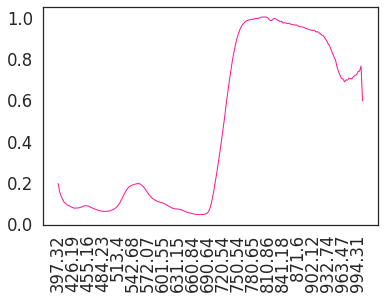

In [25]:
x_Axis = np.arange(1,205,10)

plt.plot(df.columns[16:-2],df[df.columns[16:-2]].iloc[5],lw=1)
# plt.plot(df.columns[16:-2],df[df.columns[16:-2]].iloc[30],lw=1)
# plt.plot(df.columns[16:-2],df[df.columns[16:-2]].iloc[80])
# plt.plot(df.columns[16:-2],df[df.columns[16:-2]].iloc[200])
# Here you specify the ticks you want to display
# You can also specify rotation for the tick labels in degrees or with keywords.
plt.xticks(df.columns[16:-2][::10],  rotation='vertical')

# Add margins (padding) so that markers don't get clipped by the axes

# plt.axvline(x = '810.86', color = 'magenta',lw=2)
# plt.axvline(x = '813.89', color = 'magenta',lw=2, label = "0.31")

# plt.axvline(x = '813.89', color = 'black',lw=2)
# plt.axvline(x = '807.84', color = 'black',lw=2, label = "0.31")

## **2. Group by Species**

### **Photosynthesis Rate** (An)

In [12]:
df_group_avg = df.groupby('Species').mean()
# Sort by species (for palette later)
df_group_avg.index = df_group_avg.index.str.strip()
df_group_avg = df_group_avg.reindex(['Tradescantia', 'Peperomia', 'Spathiphyllum', 'Philodendron', 'Monalisa', 'Chlorophytum'])
df_group_avg

,Unnamed: 0,Leaf,Flir_T,Flir_std,E,A,Ca,Ci,gsw,Qin,...,978.88,981.96,985.05,988.13,991.22,994.31,997.4,1000.49,1003.58,Leaf_hs
Species,,,,,,,,,,,,,,,,,,,,,
Tradescantia,182.00000,1.0,24.011589,0.057873,0.000417,3.389846,514.180655,1220.826876,0.033553,65.096428,...,0.657595,0.662660,0.666123,0.671000,0.675538,0.683738,0.689357,0.695866,0.577897,1.0
Peperomia,183.55102,2.0,24.181410,0.062313,0.000591,3.995811,507.201975,-676.536110,0.048384,66.634451,...,0.600246,0.604542,0.609558,0.613264,0.619459,0.625416,0.632446,0.639834,0.518991,2.0
Spathiphyllum,189.46000,3.0,23.787162,0.090555,0.000927,5.210603,496.970481,5171.563573,0.076663,69.999998,...,0.658737,0.659656,0.662930,0.663592,0.666540,0.667733,0.671238,0.674777,0.529345,3.0
Philodendron,191.00000,5.0,24.503921,0.068662,0.000186,2.708384,496.063876,-824.902905,0.014556,60.586202,...,0.568434,0.572387,0.575164,0.581511,0.588150,0.592533,0.600078,0.605545,0.515686,5.0
Monalisa,194.00000,4.0,23.776817,0.066681,0.000911,3.501554,491.266869,-1749.214629,0.075646,51.565352,...,0.802174,0.804885,0.807672,0.814323,0.819688,0.823174,0.827730,0.834695,0.664952,4.0
Chlorophytum,199.50000,6.0,23.274728,0.068030,0.000514,2.459006,491.632240,-435.756013,0.041286,46.983946,...,0.451945,0.454834,0.455616,0.460513,0.463972,0.466628,0.469486,0.472535,0.404222,6.0


In [37]:
ndsi_grouop = NDSI(df_group_avg[df_group_avg.columns[13:-2]],df_group_avg['A']) #wl vs A
ndsi_grouop.sort_values('Abs_Spearman_Corr')

1 done
2 done
3 done
4 done


,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"997.4,1000.49",997.4,1000.49,0.028571,0.957155,0.028571
"484.23,501.72",484.23,501.72,0.028571,0.957155,0.028571
"484.23,498.8",484.23,498.8,0.028571,0.957155,0.028571
"484.23,495.89",484.23,495.89,0.028571,0.957155,0.028571
"628.18,678.71",628.18,678.71,-0.028571,0.957155,0.028571
...,...,...,...,...,...
"408.85,717.54",408.85,717.54,-1.000000,0.000000,1.000000
"400.2,723.53",400.2,723.53,-1.000000,0.000000,1.000000
"397.32,729.53",397.32,729.53,-1.000000,0.000000,1.000000
"795.74,801.79",795.74,801.79,1.000000,0.000000,1.000000


1. Take just Correlation above 0.8.
2. Just bands with difference of n nanometers.

In [92]:
sort_An = ndsi_grouop[ndsi_grouop['Abs_Spearman_Corr']>=0.8] # correlation above 0.8
sort_An['band1'] = pd.to_numeric(sort_An['band1'])
sort_An['band2'] = pd.to_numeric(sort_An['band2'])
sort_An['diff_bands'] = sort_An['band1']-sort_An['band2'] # Difference between wl
sort_An['diff_bands'] = sort_An['diff_bands'].abs() #absulute values
n = 30 # set the difference between wl:
# sort_An[sort_An['diff_bands']>n]
sort_An

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr,diff_bands
"397.32,714.55",397.32,714.55,-0.885714,0.018845,0.885714,317.23
"397.32,717.54",397.32,717.54,-0.942857,0.004805,0.942857,320.22
"397.32,720.54",397.32,720.54,-1.000000,0.000000,1.000000,323.22
"397.32,723.53",397.32,723.53,-1.000000,0.000000,1.000000,326.21
"397.32,726.53",397.32,726.53,-1.000000,0.000000,1.000000,329.21
...,...,...,...,...,...,...
"838.14,841.18",838.14,841.18,0.942857,0.004805,0.942857,3.04
"838.14,844.22",838.14,844.22,0.828571,0.041563,0.828571,6.08
"838.14,847.25",838.14,847.25,0.828571,0.041563,0.828571,9.11
"838.14,853.33",838.14,853.33,0.828571,0.041563,0.828571,15.19


In [16]:
palette =["deeppink","lime","Orange","forestgreen","red","cyan"]
sns.set_theme(style="white",font_scale = 1.5, palette=palette)
def plot_2bands(df,band1,band2,y_col):
  fig, ax = plt.subplots(1, figsize=(6,4))
  # parameters:
  colors = df_group_avg.index # colors by species
  NI = (df[band1]-df[band2])/(df[band1]+df[band2]) #normalized index

  x = NI
  y = df[y_col]
  mask = ~np.isnan(x) & ~np.isnan(y) #not nan values
  slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
  r2 =  round(r_value**2,2)
  # scatter
  ax = sns.scatterplot(data=df,x=x[mask], y=y[mask],s=200, hue=colors,edgecolors='black',palette=palette)
  # Regression line:
  ax = sns.lineplot(x=x[mask], y=x[mask]*slope+intercept,
                    color = "black",lw = 3,
                    label = f"$R^2$ = {r2} \n p = {round(p_value,2)} ")
  ax.set_xlabel("NDSI: "+ band1+" Vs "+band2,fontsize=15)
  ax.set_ylabel(y_col,fontsize=15)
  ax.set_title("NDSI",fontsize=20)
  plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5),fontsize=14)

Plot the bands on graph function:

In [82]:
def plot_lines(band1,band2,xticks_diff=20):
  fig, ax = plt.subplots(1, figsize=(6,4))
  ax.plot(df.columns[16:-2],df[df.columns[16:-2]].iloc[80],color = "black")
  # Here you specify the ticks you want to display
  plt.xticks(df.columns[16:-2][::xticks_diff],  rotation='vertical')
  # vertical lines:
  ax.axvline(x = band1, color = 'magenta',lw=2,ls='--',label = band1)
  ax.axvline(x = band2, color = 'magenta',lw=2,label = band2)
  plt.legend()

  return

#### **Plots**

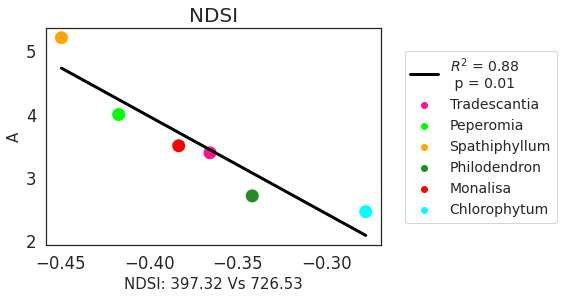

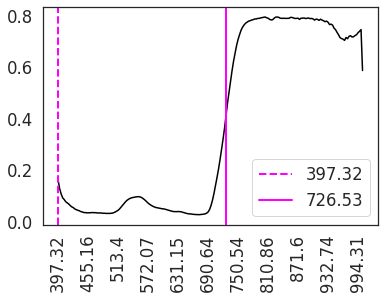

In [83]:
plot_2bands(df_group_avg,'397.32','726.53','A')
plot_lines('397.32','726.53')

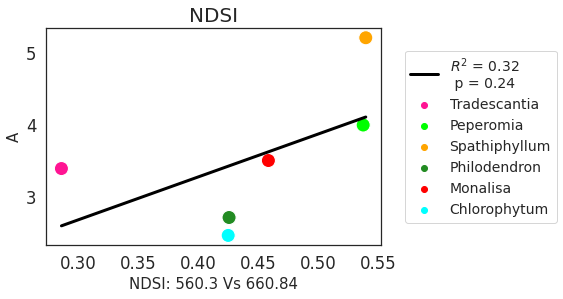

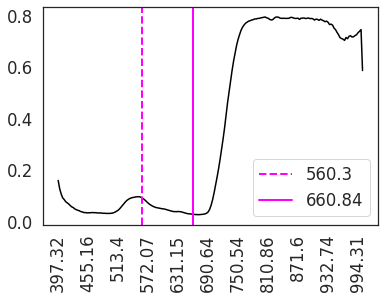

In [93]:
plot_2bands(df_group_avg,'560.3','660.84','A')
plot_lines('560.3','660.84')	

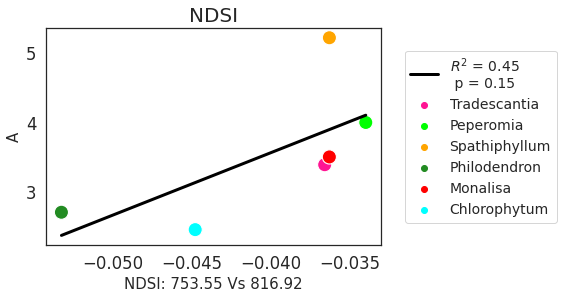

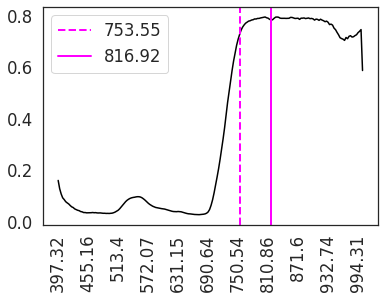

In [94]:
plot_2bands(df_group_avg,'753.55','816.92','A')
plot_lines('753.55','816.92')

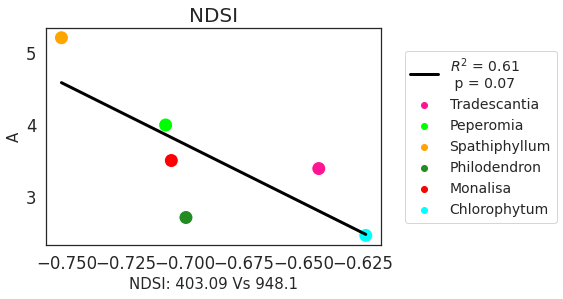

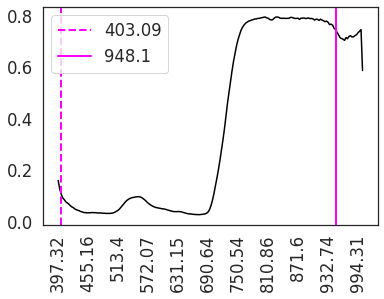

In [95]:
plot_2bands(df_group_avg,'403.09','948.1','A')
plot_lines('403.09','948.1')	

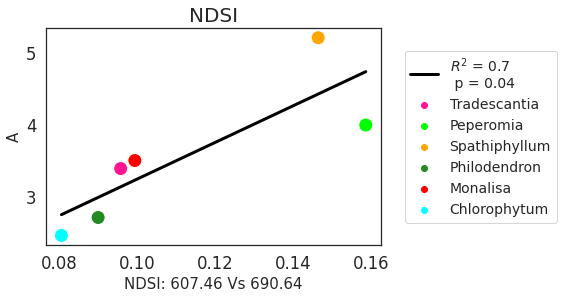

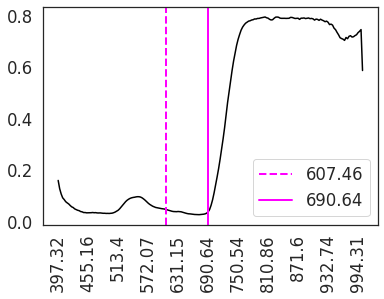

In [96]:
plot_2bands(df_group_avg,'607.46','690.64','A')
plot_lines('607.46','690.64')	

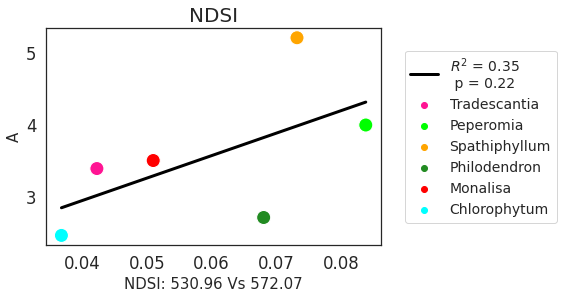

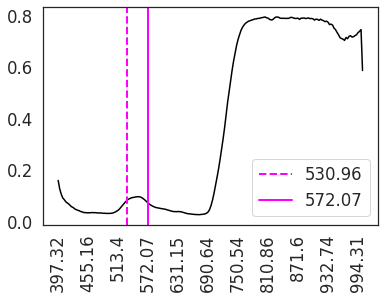

In [97]:
plot_2bands(df_group_avg,'530.96','572.07','A')
plot_lines('530.96','572.07')

### **Transpiration Rate** (E)

Here also I will group the data by Species:

In [40]:
ndsi_grouop_e = NDSI(df_group_avg[df_group_avg.columns[13:-2]],df_group_avg['E'])
ndsi_grouop_e.sort_values('Abs_Spearman_Corr')

1 done
2 done
3 done
4 done


,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"666.79,862.46",666.79,862.46,0.028571,0.957155,0.028571
"672.75,783.67",672.75,783.67,0.028571,0.957155,0.028571
"672.75,786.68",672.75,786.68,0.028571,0.957155,0.028571
"672.75,789.7",672.75,789.7,0.028571,0.957155,0.028571
"672.75,792.72",672.75,792.72,0.028571,0.957155,0.028571
...,...,...,...,...,...
"437.76,708.57",437.76,708.57,-0.942857,0.004805,0.942857
"774.62,810.86",774.62,810.86,0.942857,0.004805,0.942857
"777.64,816.92",777.64,816.92,0.942857,0.004805,0.942857
"816.92,826.01",816.92,826.01,-0.942857,0.004805,0.942857


In [46]:
sort_e = ndsi_grouop_e.sort_values('Abs_Spearman_Corr')
sort_e[sort_e['Abs_Spearman_Corr']>0.8]

,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"908.24,914.36",908.24,914.36,-0.828571,0.041563,0.828571
"981.96,988.13",981.96,988.13,0.828571,0.041563,0.828571
"994.31,997.4",994.31,997.4,0.828571,0.041563,0.828571
"908.24,957.32",908.24,957.32,-0.828571,0.041563,0.828571
"972.71,997.4",972.71,997.4,0.828571,0.041563,0.828571
...,...,...,...,...,...
"437.76,708.57",437.76,708.57,-0.942857,0.004805,0.942857
"774.62,810.86",774.62,810.86,0.942857,0.004805,0.942857
"777.64,816.92",777.64,816.92,0.942857,0.004805,0.942857
"816.92,826.01",816.92,826.01,-0.942857,0.004805,0.942857


#### Plots

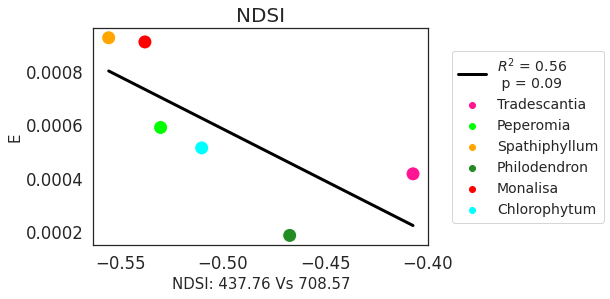

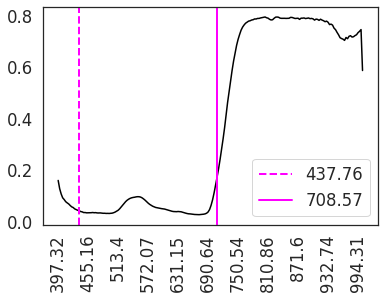

In [84]:
plot_2bands(df_group_avg,'437.76','708.57','E')
plot_lines('437.76','708.57')

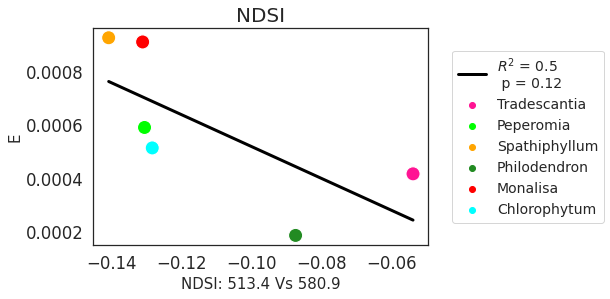

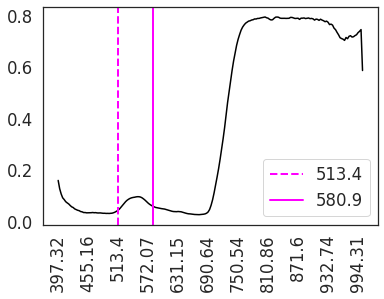

In [85]:
plot_2bands(df_group_avg,'513.4','580.9','E')
plot_lines('513.4','580.9')

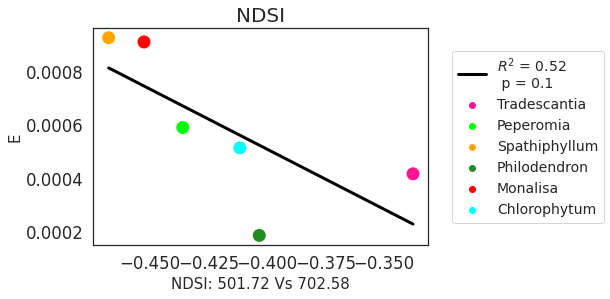

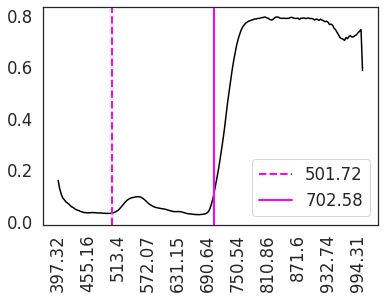

In [86]:
plot_2bands(df_group_avg,'501.72','702.58','E')
plot_lines('501.72','702.58')

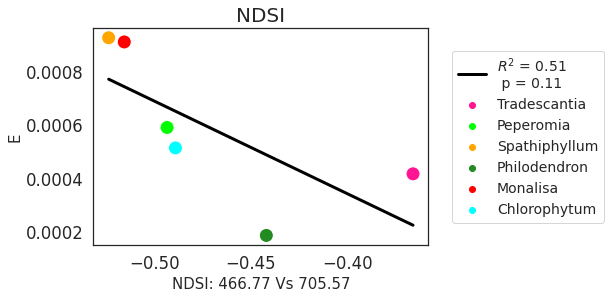

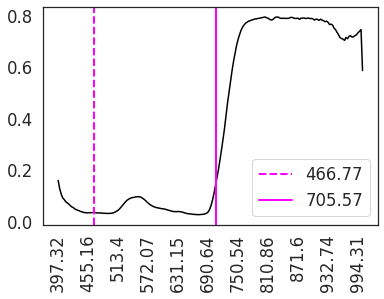

In [87]:
plot_2bands(df_group_avg,'466.77','705.57','E')
plot_lines('466.77','705.57')

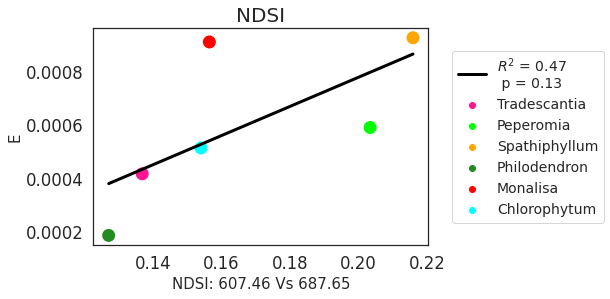

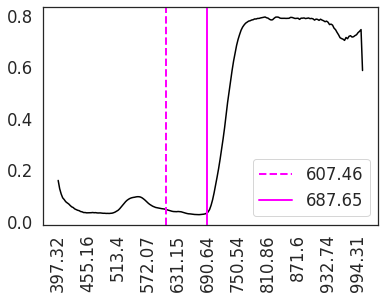

In [88]:
plot_2bands(df_group_avg,'607.46','687.65','E')
plot_lines('607.46','687.65')

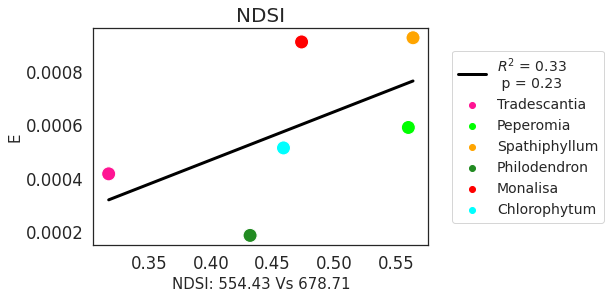

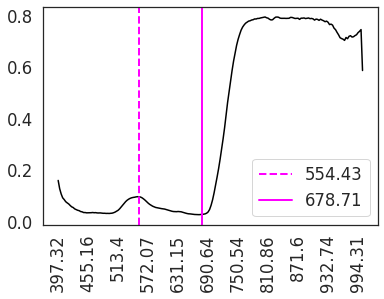

In [89]:
plot_2bands(df_group_avg,'554.43','678.71','E')
plot_lines('554.43','678.71')

In [19]:
def plot_2columns(df,col1,col2):
  fig, ax = plt.subplots(1, figsize=(6,4))
  # parameters:
  colors = df_group_avg.index # colors by species

  x = df[col1]
  y = df[col2]
  mask = ~np.isnan(x) & ~np.isnan(y) #not nan values
  slope, intercept, r_value, p_value, std_err = stats.linregress(x[mask], y[mask])
  r2 =  round(r_value**2,2)
  # scatter
  ax = sns.scatterplot(data=df,x=x[mask], y=y[mask],s=200, hue=colors,edgecolors='black',palette=palette)
  # Regression line:
  ax = sns.lineplot(x=x[mask], y=x[mask]*slope+intercept,
                    color = "black",lw = 3,
                    label = f"$R^2$ = {r2} \n p = {round(p_value,2)} ")


  ax.set_xlabel(col1,fontsize=15)
  ax.set_ylabel(col2,fontsize=15)
  ax.set_title(str(col2) + " Vs " + str(col1),fontsize=20)
  plt.legend(loc=6, bbox_to_anchor=(1.05, 0.5),fontsize=14)

  return

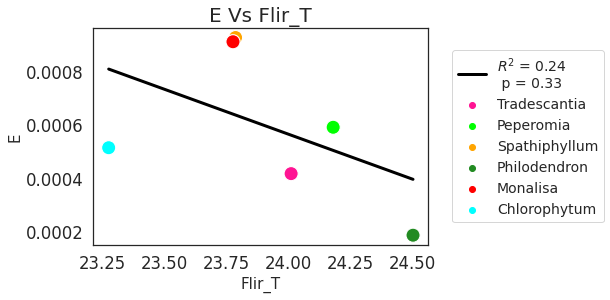

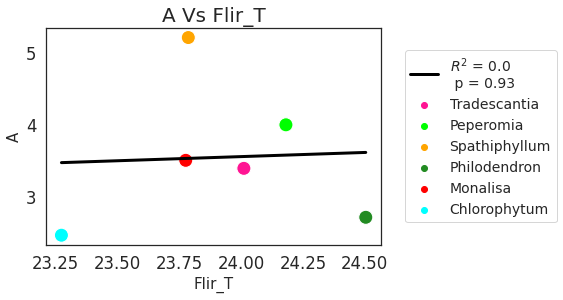

In [20]:
plot_2columns(df_group_avg,'Flir_T','E')
plot_2columns(df_group_avg,'Flir_T','A')

In [22]:
a = df.groupby(['date', 'Species']).mean()

In [23]:
ndsi_grouop = NDSI(a[a.columns[14:-2]],a['A'])
ndsi_grouop.sort_values('Abs_Spearman_Corr')

1 done
2 done
3 done
4 done


,band1,band2,Spearman_Corr,p_value,Abs_Spearman_Corr
"598.6,750.54",598.6,750.54,0.000006,9.999550e-01,0.000006
"516.33,997.4",516.33,997.4,-0.000006,9.999550e-01,0.000006
"504.64,865.5",504.64,865.5,-0.000006,9.999550e-01,0.000006
"595.65,826.01",595.65,826.01,0.000028,9.997750e-01,0.000028
"753.55,850.29",753.55,850.29,0.000028,9.997750e-01,0.000028
...,...,...,...,...,...
"804.81,813.89",804.81,813.89,0.396690,3.664476e-05,0.396690
"423.29,426.19",423.29,426.19,-0.399020,3.265136e-05,0.399020
"829.04,832.07",829.04,832.07,-0.402186,2.787323e-05,0.402186
"807.84,813.89",807.84,813.89,0.451584,1.898667e-06,0.451584
